## SIR-like adaption of the hodgkin huxley neuron Model

### ACME Volume 4 Project: Rex Boyce, Daniel Christiensen, Ed Ringger, Stephen Yacktman

### This code was adapted from this "Intro to the Hodgkin Huxley Model using Python" code found online at the following link: 

https://hodgkin-huxley-tutorial.readthedocs.io/en/latest/_static/Hodgkin%20Huxley.html

In [12]:
import scipy as sp
import pylab as plt
import numpy as np
from scipy.integrate import odeint

plt.rcParams["figure.figsize"] = (20, 14)
Z = 10

%matplotlib inline

In [19]:

class HodgkinHuxley():
    """Full Modified Hodgkin-Huxley Model implemented in Python"""

    C_m  =   1.0
    """membrane capacitance, in uF/cm^2"""

    g_Na = 120.0
    """Sodium (Na) maximum conductances, in mS/cm^2"""

    g_K  =  36.0
    """Postassium (K) maximum conductances, in mS/cm^2"""

    g_L  =   0.3
    """Leak maximum conductances, in mS/cm^2"""

    E_Na =  50.0
    """Sodium (Na) Nernst reversal potentials, in mV"""

    E_K  = -77.0
    """Postassium (K) Nernst reversal potentials, in mV"""

    E_L  = -54.387
    """Leak Nernst reversal potentials, in mV"""

    t = sp.arange(0.0, 450.0, 0.01)
    """ The time to integrate over """

    def o(self, V, scalar=0.75):
        return (np.tanh((V + 55) * scalar) / 2) + 0.5

## Below are some other activation functions we tried for o
#     def o(self, V):
#         return int(V > -55)
#     def o(self, V):
#         return 1/(1+np.e**(-Z*(V+55)))
#     def o(self, V, stdev=10):
#         return 1/(np.sqrt(2*np.pi))* np.exp(-1* (V +55)**2 / (2*stdev ** 2))

    def d(self, V, scalar=0.75):
        return 1

## Below are some other activation functions we tried for d
#     def d(self, V):
#         return int(V > 30)
#     def d(self, V):
#         return 1/(1+np.e**(-Z*(V-30)))
#     def d(self, V, stdev=10):
#         return 1/(np.sqrt(2*np.pi))* np.exp(-1* (V - 30)**2 / (2*stdev ** 2))

    def r(self, V):
        return int(V < -65)

## Below are some other alternate activation functions we tried for r
#    def r(self, V):
#        return 1/(1+np.e**(-Z*(V+65)))
#     def r(self, V, stdev=10):
#        return 1/(np.sqrt(2*np.pi))* np.exp(-1* (V +65)**2 / (2*stdev ** 2))
#     def r(self, V, scalar=1):
#         return (np.tanh((V + 65) * scalar) / 2) + 0.5


    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*(V+55.0)/(1.0 - np.exp(-(V+55.0) / 10.0))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*sp.exp(-(V+65) / 80.0)

    def I_Na(self, V, c, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)
        """
        return self.g_Na * (1 - c - h) * (V - self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_K  * n**4 * (V - self.E_K)
    
    #  Leak
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak

        |  :param V:
        |  :param h:
        |  :return:
        """
        return self.g_L * (V - self.E_L)

    def I_inj(self, t):
        """
        External Current

        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        """
        ## NOTE: the following line used to read # + 35*(t>300) - 35*(t>400)
        return 10*(t>100) - 10*(t>200) + 25*(t>300) - 25*(t>400)

    @staticmethod
    def dALLdt(X, t, self):
        """
        Integrate

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, c, h, n = X

        dVdt = (self.I_inj(t) - self.I_Na(V, c, h) - self.I_K(V, n) - self.I_L(V)) / self.C_m
        
        # our new SIR model
        dcdt = self.r(V)*h - self.o(V)*c
        dhdt = self.d(V)*(1 - c - h) - self.r(V)*h
        
        dndt = self.alpha_n(V)*(1.0-n) - self.beta_n(V)*n
        return dVdt, dcdt, dhdt, dndt

    def Main(self):
        """
        Main demo for our altered Hodgkin Huxley neuron model
        """
        # TODO: new initial conditions
        X = odeint(self.dALLdt, [-65, 1, 0, 0.32], self.t, args=(self,))
        
        V = X[:,0]
        c = X[:,1]
        h = X[:,2]
        n = X[:,3]
        
        ina = self.I_Na(V, c, h)
        ik = self.I_K(V, n)
        il = self.I_L(V)

        plt.figure(figsize=(15,10))

        plt.subplot(4,1,1)
        plt.title('Modified SIR-like Hodgkin-Huxley Neuron Model')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V (mV)')

        plt.subplot(4,1,2)
        plt.plot(self.t, ina, 'c', label='$I_{Na}$')
        plt.plot(self.t, ik, 'y', label='$I_{K}$')
        plt.plot(self.t, il, 'm', label='$I_{L}$')
        plt.ylabel('Current')
        plt.legend()

        plt.subplot(4,1,3)
        plt.plot(self.t, c, 'r', label='c')
        plt.plot(self.t, h, 'g', label='h')
        plt.plot(self.t, 1 - c - h, 'y', label='m')
        plt.plot(self.t, n, 'b', label='n')
        plt.ylabel('Gating Value')
        plt.legend()

        plt.subplot(4,1,4)
        i_inj_values = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj_values, 'k')
        plt.xlabel('t (ms)')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)

        plt.show()

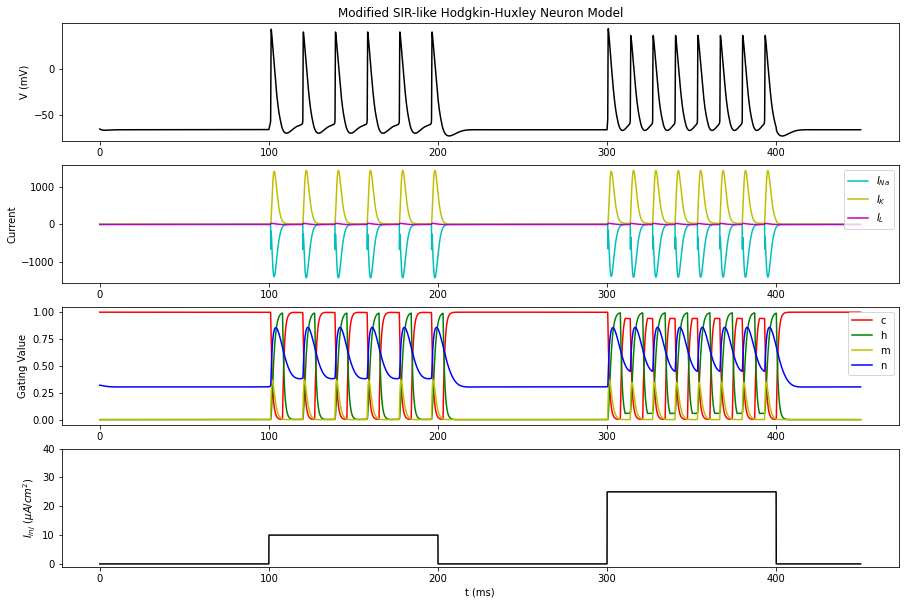

In [20]:
runner = HodgkinHuxley()
runner.Main()